In [1]:
import os
import sys
import h5py
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
from keras.models import Input, Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Activation, GRU, BatchNormalization
from keras.utils import Sequence
from keras import backend as K
from keras.optimizers import adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
from modis_utils.misc import cache_data, restore_data

In [4]:
scale_data = False

In [5]:
data = restore_data(os.path.join('cache', 'boundary_vectors_ALL.h5'))

In [6]:
train_boundary_vectors = data[0]
val_boundary_vectors = data[1]
test_boundary_vectors = data[2]

In [7]:
train_boundary_vectors.shape, val_boundary_vectors.shape, test_boundary_vectors.shape

((438, 1024, 2), (138, 1024, 2), (138, 1024, 2))

In [8]:
n_points = train_boundary_vectors.shape[1]

In [9]:
data_1 = np.concatenate(data, axis=0)

In [10]:
train_boundary_vectors = data_1[:-92]
val_boundary_vectors = data_1[-92:-46]
test_boundary_vectors = data_1[-46:]

In [11]:
train_boundary_vectors.shape, val_boundary_vectors.shape, test_boundary_vectors.shape

((622, 1024, 2), (46, 1024, 2), (46, 1024, 2))

In [12]:
def transform(data, scaler):
    old_shape = data.shape
    data = data.reshape(old_shape[0], -1)
    if scaler is not None:
        data = scaler.transform(data.astype(np.float))
    return data.reshape(old_shape)
    #return data

def transform_standardize(data, mean, std):
    old_shape = data.shape
    data = data.reshape(-1, old_shape[1]*old_shape[2])
    data = (data - mean)/std
    return data.reshape(old_shape)
    #return data

def find_mean_std(data):
    old_shape = data.shape
    data = data.reshape(-1, old_shape[1]*old_shape[2])
    mean = np.mean(data, axis=0).reshape(1, -1)
    std = np.std(data, axis=0).reshape(1, -1)
    std[std == 0] = 1
    #mean = mean.reshape(-1, old_shape[-1])
    #std = std.reshape(-1, old_shape[-1])
    return mean, std

In [13]:
scaler = None
scale_data = False
if scale_data:
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_boundary_vectors.reshape(train_boundary_vectors.shape[0], -1))

mean, std = find_mean_std(train_boundary_vectors)
train_boundary_vectors_1 = transform_standardize(train_boundary_vectors, mean, std)
val_boundary_vectors_1 = transform_standardize(val_boundary_vectors, mean, std)
test_boundary_vectors_1 = transform_standardize(test_boundary_vectors, mean, std)

In [14]:
def create_dataset(boundary_vectors_scale, timesteps):
    data_X = []
    data_Y = []
    for i in range(len(boundary_vectors_scale) - timesteps):
        data_x = boundary_vectors_scale[i:(i+timesteps)]
        data_y = boundary_vectors_scale[i + timesteps]
        data_X.append(data_x)
        data_Y.append(data_y)
    return np.asarray(data_X), np.asarray(data_Y)

In [15]:
from numpy import polyfit

In [16]:
plt.rcParams['figure.figsize'] = (20, 8)

In [17]:
n_years = len(data_1)//46

In [18]:
data_2 = data_1[:24].copy()
data_3 = data_1[24:]
for i in range(n_years):
    year = 2003 + i
    if year != 2011 and year != 2013:
        data_2 = np.vstack([data_2, data_3[i*46 : (i + 1)*46]])

data_1.shape, data_2.shape

((714, 1024, 2), (622, 1024, 2))

/usr/local/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Coefficients: [-0.00000000e+000  0.00000000e+000 -0.00000000e+000  0.00000000e+000
  0.00000000e+000 -0.00000000e+000  0.00000000e+000 -0.00000000e+000
 -2.89361570e-142  1.69555679e-141  3.76612581e-139  1.94433623e-137
  6.84942205e-136  1.55573599e-134 -5.72633176e-134 -3.25139840e-131
 -2.42141703e-129 -1.30230681e-127 -5.81632267e-126 -2.20017012e-124
 -6.66146173e-123 -1.17379552e-121  3.39129834e-120  5.13142801e-118
  3.60157840e-116  1.98846084e-114  9.46812603e-113  3.96920277e-111
  1.43836955e-109  4.12916783e-108  5.81514976e-107 -3.45352648e-105
 -4.10618831e-103 -2.77817483e-101 -1.51946302e-099 -7.22105765e-098
 -3.02206686e-096 -1.08615555e-094 -3.01925086e-093 -3.31715662e-092
  3.39975405e-090  3.56626094e-088  2.32190262e-086  1.23014261e-084
  5.60926458e-083  2.19576049e-081  6.91822978e-080  1.27842488e-078
 -3.59355611e-077 -5.67753787e-075 -4.01289080e-073 -2.17667592e-071
 -9.81527631e-070 -3.63583359e-068 -9.71733406e-067 -4.52825575e-066
  1.65679969e-063  1

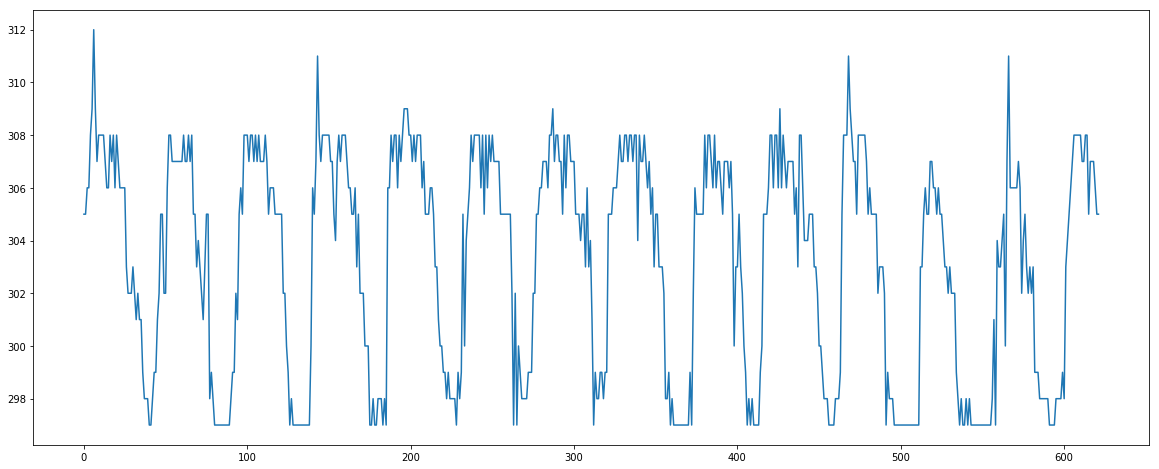

In [20]:
X = [i%46 for i in range(0, len(data_2))]
y = data_2[:, 0, 1]
degree = 100
coef1 = polyfit(X, y, degree)
print('Coefficients: %s' % coef1)
# create curve
curve1 = list()
for i in range(len(X)):
    value = coef1[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef1[d]
    curve1.append(value)
    
# plot curve over original data
plt.plot(y)
#plt.plot(curve1, color='red', linewidth=3)
plt.savefig('figs/y_coordinate_0.png')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Coefficients: [-2.38871722e-73  2.31865425e-71  1.21082545e-70 -3.06204564e-68
 -1.39812907e-66 -1.39454253e-65  1.78464481e-63  1.29371014e-61
  4.46338983e-60  3.01625513e-59 -6.82781311e-57 -5.09722784e-55
 -2.03437556e-53 -3.41228059e-52  1.82788058e-50  1.94728228e-48
  9.54311842e-47  2.48479031e-45 -2.94285501e-44 -7.20245400e-42
 -4.24318258e-40 -1.31962864e-38  2.56296312e-38  2.97788841e-35
  1.86269646e-33  5.37912602e-32 -6.90393368e-31 -1.57928258e-28
 -7.70008307e-27 -8.69294233e-26  1.22276165e-23  8.08401303e-22
  1.08904748e-20 -1.33170020e-18 -7.47547959e-17  6.04983198e-16
  1.84165169e-13  1.60815318e-12 -4.13448061e-10 -4.94271622e-10
  9.75369094e-07 -4.44093153e-05  1.05616349e-03 -1.57770966e-02
  1.55373592e-01 -1.00905997e+00  4.18270841e+00 -1.03173919e+01
  1.32084876e+01 -5.16929509e+00  2.99424576e+02]


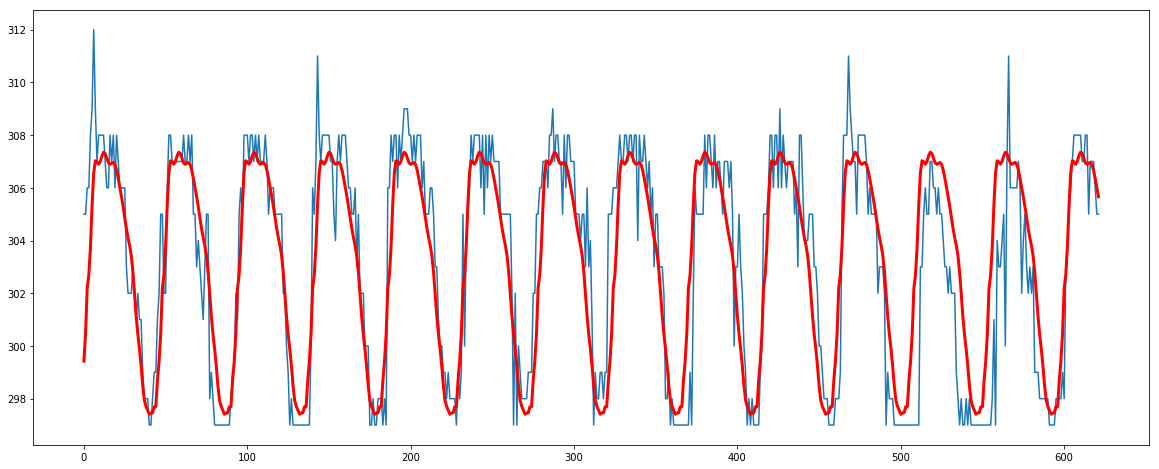

In [20]:
X = [i%46 for i in range(0, len(data_2))]
y = data_2[:, 0, 1]
degree = 50
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
plt.plot(y)
plt.plot(curve, color='red', linewidth=3)
plt.show()

In [21]:
import statsmodels.api as sm
import itertools

In [22]:
y = data_2[:-92, 0, 1]

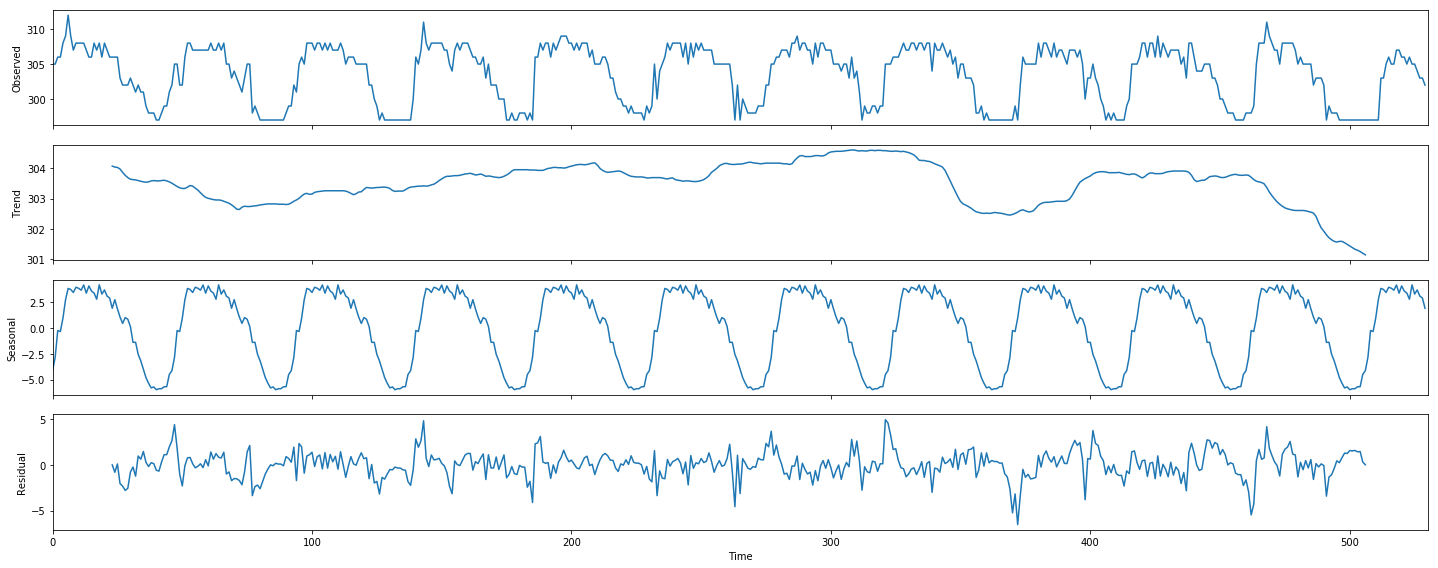

In [23]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq=46)
fig = decomposition.plot()
plt.show()

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

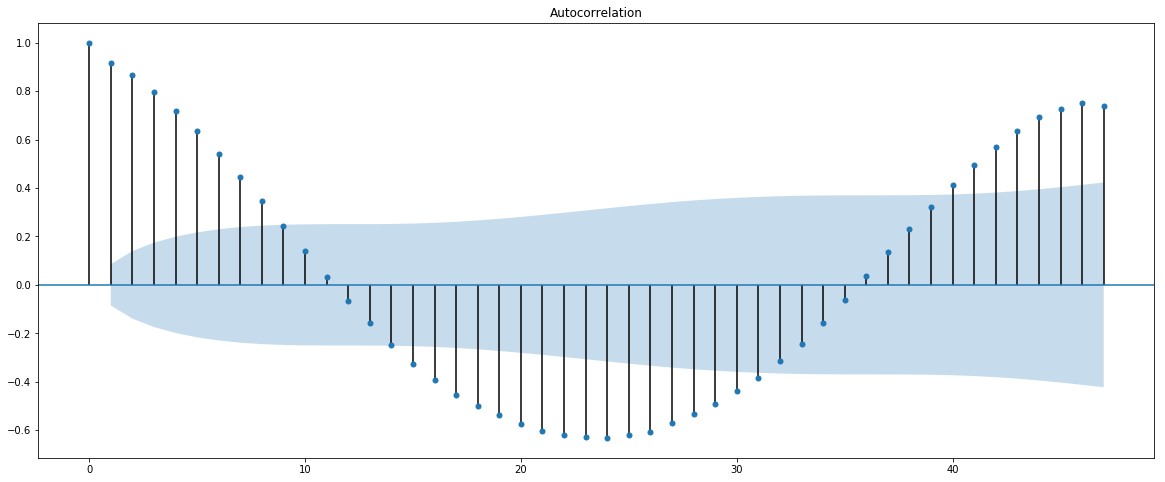

In [25]:
plot_acf(y, lags=47)
plt.show()

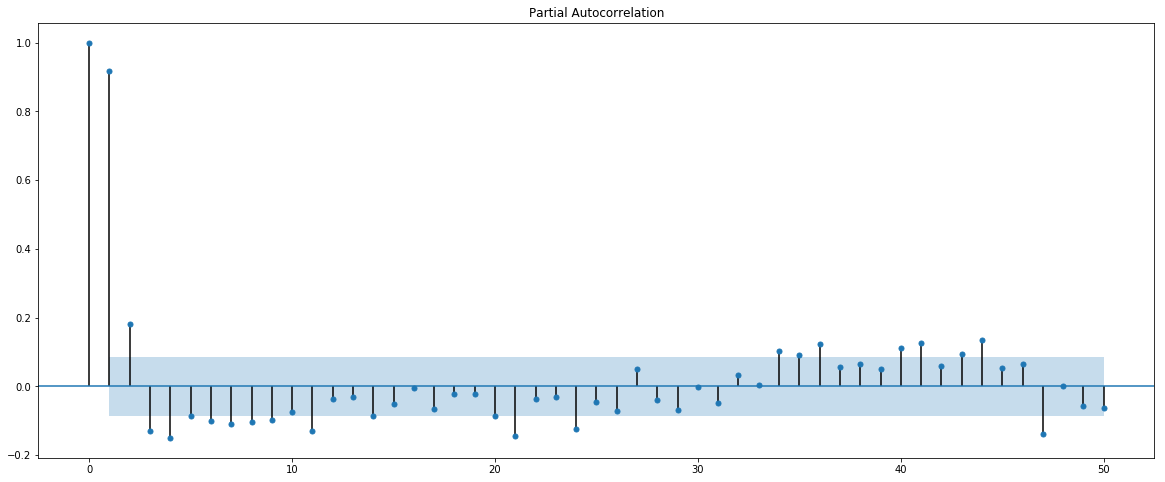

In [26]:
plot_pacf(y, lags=50)
plt.show()

In [27]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 46) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 46)
SARIMAX: (0, 0, 1) x (0, 0, 2, 46)
SARIMAX: (0, 0, 2) x (0, 1, 0, 46)
SARIMAX: (0, 0, 2) x (0, 1, 1, 46)


In [28]:
'''
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
'''

"\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(y,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n            results = mod.fit()\n            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))\n        except:\n            continue\n"

In [29]:
from time import time

In [30]:
start_time = time()
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 46),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
end_time = time()
print('Running time = {:0.1f}s'.format(end_time - start_time))
print(results.summary().tables[1])

Running time = 3.0s
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8158      0.037     22.095      0.000       0.743       0.888
ma.L1         -0.3242      0.062     -5.196      0.000      -0.446      -0.202
ar.S.L46      -0.4592      0.033    -13.767      0.000      -0.525      -0.394
sigma2         2.7594      0.135     20.509      0.000       2.496       3.023


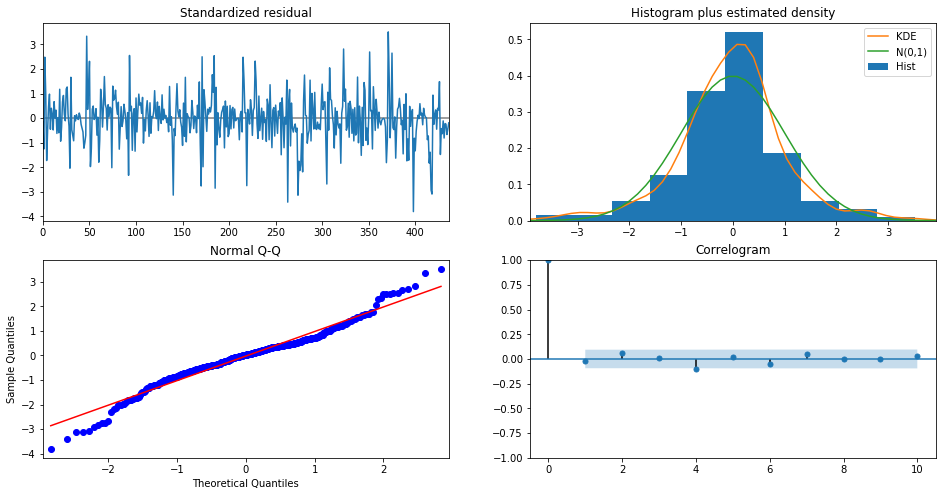

In [31]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [32]:
pred = results.forecast(92)

In [33]:
gtruth = data_2[-92:, 0, 1]

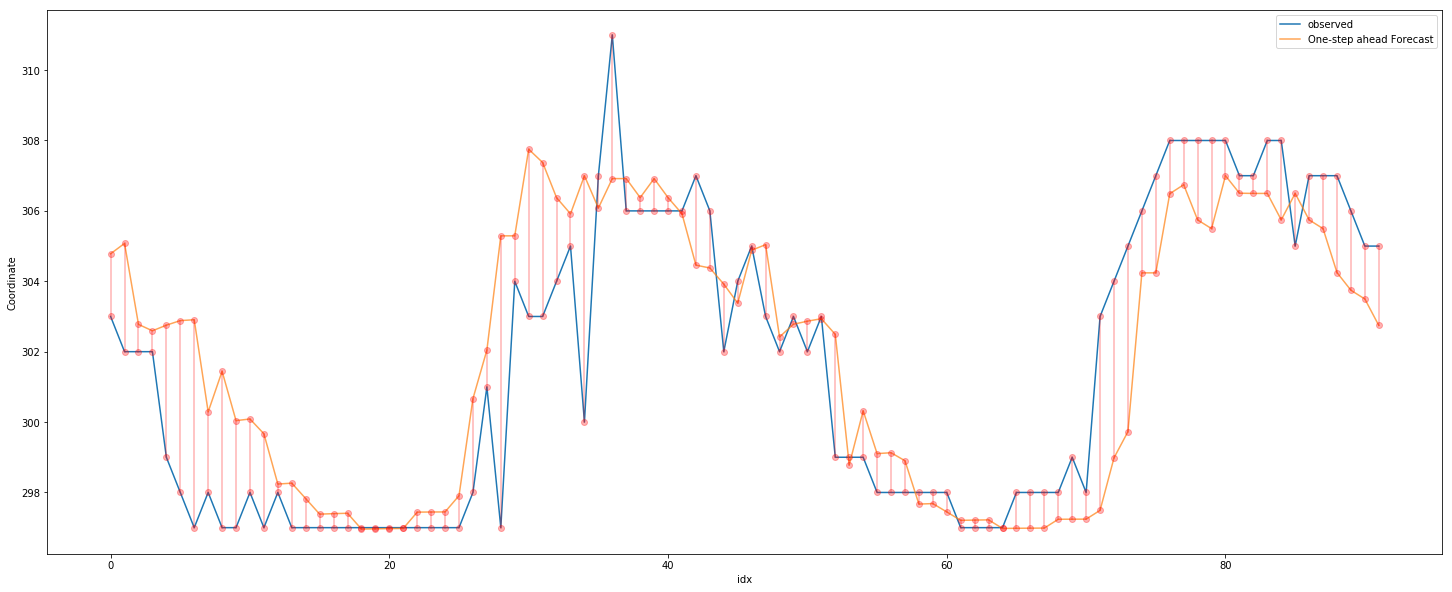

In [34]:
fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.plot(gtruth, label='observed')
ax.plot(pred, label='One-step ahead Forecast', alpha=.7)

y1 = np.concatenate([gtruth.reshape(-1, 1), pred.reshape(-1, 1)], axis=-1)
for i in range(0, len(y1)):
    plt.plot([i, i], y1[i], 'ro-', alpha=0.3)

ax.set_xlabel('idx')
ax.set_ylabel('Coordinate')
plt.legend()
plt.show()

In [35]:
np.mean((gtruth - pred)**2)

5.645421252894728

In [36]:
import statsmodels

In [37]:
statsmodels.__version__

'0.9.0'

In [38]:
data_2.shape

(622, 1024, 2)

In [39]:
data = data_2.reshape(data_2.shape[0], -1)
data.shape

(622, 2048)

In [40]:
n_tests = 92
data_train = data[:-n_tests]

In [41]:
data_train.shape

(530, 2048)

In [42]:
import pandas as pd

In [43]:
data = data_2.reshape(data_2.shape[0], -1)
data.shape

(622, 2048)

In [44]:
df = pd.DataFrame(data=data)

In [45]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,256.0,305.0,256.0,305.0,257.0,307.0,257.0,307.0,257.0,306.0,...,255.0,303.0,255.0,303.0,255.0,306.0,255.0,306.0,255.0,306.0
1,256.0,305.0,256.0,305.0,257.0,307.0,257.0,307.0,257.0,306.0,...,254.0,305.0,255.0,305.0,255.0,306.0,255.0,306.0,255.0,306.0
2,256.0,306.0,256.0,306.0,257.0,308.0,257.0,308.0,257.0,306.0,...,254.0,306.0,255.0,305.0,255.0,307.0,255.0,307.0,255.0,307.0
3,256.0,306.0,256.0,306.0,257.0,310.0,257.0,310.0,257.0,307.0,...,254.0,306.0,255.0,305.0,255.0,306.0,255.0,306.0,255.0,306.0
4,256.0,308.0,256.0,308.0,257.0,311.0,257.0,310.0,257.0,309.0,...,254.0,308.0,255.0,307.0,255.0,308.0,255.0,308.0,255.0,308.0


In [46]:
df.shape

(622, 2048)

In [47]:
df1 = df.loc[:, (df != df.iloc[0]).any()]

In [48]:
df1.shape

(622, 2021)

In [49]:
df1.head()

,1,3,5,7,8,9,10,11,12,13,...,2035,2036,2037,2038,2039,2040,2041,2043,2045,2047
0,305.0,305.0,307.0,307.0,257.0,306.0,258.0,309.0,258.0,309.0,...,303.0,254.0,304.0,255.0,303.0,255.0,303.0,306.0,306.0,306.0
1,305.0,305.0,307.0,307.0,257.0,306.0,258.0,310.0,258.0,310.0,...,304.0,254.0,305.0,254.0,305.0,255.0,305.0,306.0,306.0,306.0
2,306.0,306.0,308.0,308.0,257.0,306.0,258.0,309.0,258.0,309.0,...,304.0,254.0,306.0,254.0,306.0,255.0,305.0,307.0,307.0,307.0
3,306.0,306.0,310.0,310.0,257.0,307.0,258.0,311.0,258.0,310.0,...,305.0,254.0,306.0,254.0,306.0,255.0,305.0,306.0,306.0,306.0
4,308.0,308.0,311.0,310.0,257.0,309.0,258.0,311.0,258.0,310.0,...,306.0,254.0,308.0,254.0,308.0,255.0,307.0,308.0,308.0,308.0


In [50]:
data_train = df1[:-n_tests]
data_test = df1[-n_tests:]
data_train_12 = data_train.iloc[:, :12]
data_test_12 = data_test.iloc[:, :12]

In [51]:
def mse(x, y):
    if isinstance(x, pd.Series) or isinstance(x, pd.DataFrame):
        x = x.values
    if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
        y = y.values
    return np.mean((x - y)**2)

In [61]:
class VSARIMA1:

    def __init__(self, data_train, data_test):
        self.data_train = data_train
        self.data_test = data_test
        self.n_data = data_train.shape[-1]
        self.results = self._create_empty_list(self.n_data)
        self.log = 'log.csv'
        self.train_loss = None
        self.mean_train_loss = None
        if os.path.isfile(self.log):
            os.remove(self.log)

    def _create_empty_list(self, n):
        res = []
        for _ in range(n):
            res.append(None)
        return res

    def train(self):
        return self._train(self.data_train, self.data_test, [0, self.n_data])

    def _train(self, data_train, data_test, idx):
        start_time = time()
        train_loss = []
        for i in range(idx[0], idx[1]):
            y = data_train.iloc[:, i]
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1, 0, 1),
                                            seasonal_order=(1, 1, 0, 46),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            self.results[i] = results
            
            current_time = time()
            running_time = current_time - start_time
            current_loss = self.calc_loss(i, i, data_test)
            train_loss += current_loss
            current_mean_loss = np.mean(np.asarray(train_loss))
            with open(self.log, 'a') as f:
                f.write('{:10.3f}s,{:5d},{:8.3f}\n'.format(running_time, i, current_mean_loss))
        end_time = time()
        print("Training time = {:0.3f}s".format(end_time - start_time))
        self.train_loss = train_loss
        self.mean_train_loss = np.mean(np.asarray(train_loss))
        return self.results

    def calc_loss(self, start_idx, end_idx, data_test):
        res = []
        steps = data_test.shape[0]
        for i in range(start_idx, end_idx + 1):
            results = self.results[i]
            forecast = results.forecast(steps)
            loss = mse(forecast, data_test.iloc[:,i])
            res.append(loss)
        return res

    def inference(self, steps=1):
        res = []
        for i in range(self.n_data):
            results = self.results[i]
            res.append(results.forecast(steps))
        return pd.concat(res, ignore_index=True, axis=1)

    def eval(self, groundtruth, metric=None):
        steps = groundtruth.shape[0]
        yhat = self.inference(steps)
        if metric is None:
            metric = mse
        return yhat, metric(groundtruth, yhat)

In [62]:
data_train_12 = data_train.iloc[:, 100:110]
data_test_12 = data_test.iloc[:, 100:110]

In [63]:
vsarima1 = VSARIMA1(data_train_12, data_test_12)

In [ ]:
vsarima1.train()

In [ ]:
yhat, mse_loss = vsarima1.eval(data_test_12)
print(mse_loss)

In [ ]:
vsarima1.train_loss